In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from scipy.spatial import distance
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

### Import monthly features data and filter into two sets

In [2]:
monthly_features = pd.read_csv('mth_features.csv')

In [3]:
monthly_features = monthly_features.sort_values(by=['ME_DT'])
monthly_features = monthly_features.reset_index(drop=True)
train = monthly_features.loc[monthly_features.ME_DT<'2014-01-31']
test = monthly_features.loc[monthly_features.ME_DT>='2014-01-31']

In [4]:
x_train = train.drop(['response'], axis = 1)
y_train = train['response']
X_train = x_train.drop(['CLNT_NO','ME_DT'],axis=1)
colnames = X_train.columns
scaler = StandardScaler().fit(X_train)
X_train_std = scaler.transform(X_train)

In [5]:
X_test = test.drop(['CLNT_NO','response'], axis = 1)
y_test = test['response']

### Fit random forest model and find top 5 features

In [6]:
rf = RandomForestClassifier(n_estimators = 200, max_features="sqrt", max_depth=20, 
                            min_samples_split = 20, random_state=1148)
rf.fit(X_train_std, y_train)
importances = rf.feature_importances_

In [7]:
impor = pd.DataFrame(importances, index=colnames, columns=['Feature Importance'])
impor = impor.sort_values(by=['Feature Importance'], ascending=False)
top_5_features = impor.index[0:5]
top_5_features

Index(['days_since_last_txn', 'amt_sum_12M', 'amt_max_12M', 'amt_mean_12M',
       'amt_max_6M'],
      dtype='object')

### Compute baseline score and clients scores after Jan-2014, then compute monthly JS divergence

In [8]:
baseline_score = rf.predict_proba(X_train_std)[:,1]
bin_edges = np.quantile(baseline_score, np.arange(0, 1.1, 0.1))
bin_edges[0]=0
p = np.histogram(baseline_score, bin_edges)

In [9]:
month = X_test['ME_DT'].unique()
JS_monthly = []
for i in range(len(month)):
    test_set = X_test.loc[X_test['ME_DT']==month[i]]
    test_set = test_set.drop(['ME_DT'],axis=1)
    test_set_std = scaler.transform(test_set)
    predict_test = rf.predict_proba(test_set_std)[:,1]
    q = np.histogram(predict_test,bin_edges)
    JS_monthly.append(distance.jensenshannon(p[0],q[0],2.0))

### Compute Jensen-Shannon divergence metric for the top 5 features

In [10]:
JS_feature = pd.DataFrame(index=top_5_features,columns=np.arange(0,15))
bin_edge = np.r_[-np.inf, bin_edges , np.inf]
for i in range(len(month)):
    for j in range(len(top_5_features)):
        test_set = X_test.loc[X_test['ME_DT']==month[i]][top_5_features[j]]
        baseline_set = X_train[top_5_features[j]]
        target_score = test_set/test_set.max()
        baseline_score= baseline_set/baseline_set.max()
        p = np.histogram(baseline_score, bin_edge)
        q = np.histogram(target_score, bin_edge)
        JS_feature.at[top_5_features[j],i] = distance.jensenshannon(p[0], q[0], 2.0)

### Plot the monthly JS divergence with time

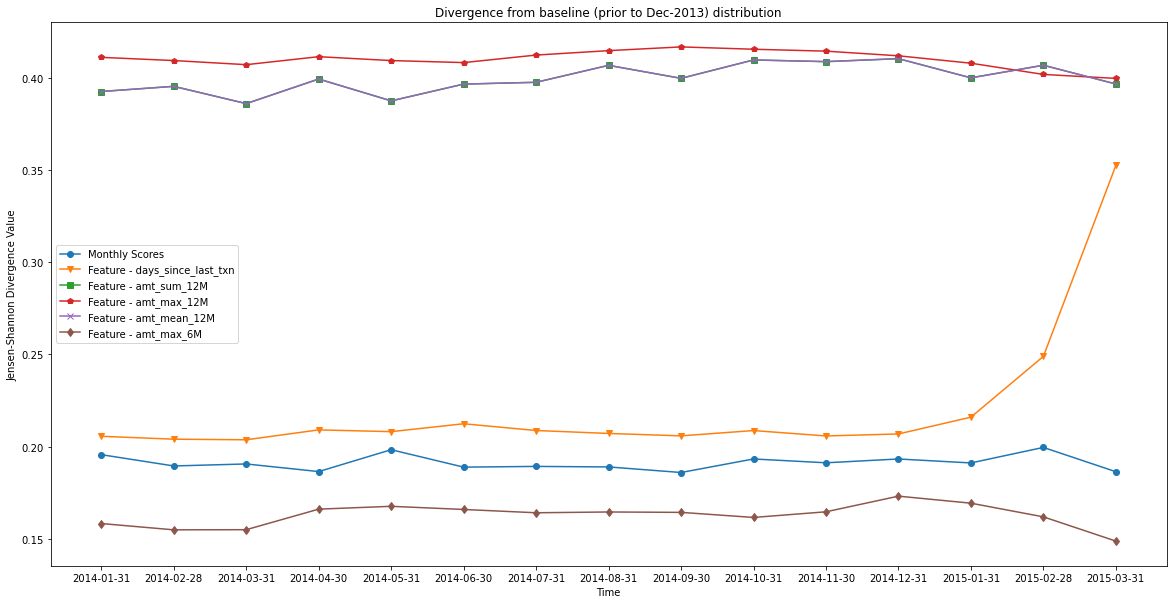

In [11]:
plt.figure(figsize=(20,10))
plt.plot(month, JS_monthly, '-o', label = 'Monthly Scores')
plt.plot(month, JS_feature.iloc[0,:], '-v', label = 'Feature - days_since_last_txn')
plt.plot(month, JS_feature.iloc[1,:], '-s', label = 'Feature - amt_sum_12M')
plt.plot(month, JS_feature.iloc[2,:], '-p', label = 'Feature - amt_max_12M')
plt.plot(month, JS_feature.iloc[3,:], '-x', label = 'Feature - amt_mean_12M')
plt.plot(month, JS_feature.iloc[4,:], '-d', label = 'Feature - amt_max_6M')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Jensen-Shannon Divergence Value')
plt.title('Divergence from baseline (prior to Dec-2013) distribution')
plt.show()

Implementing the random forest model with n_estimators = 200, max_features="sqrt", max_depth=20, min_samples_split = 20, we found the top 5 features with highest feature importance are 'days_since_last_txn', 'amt_sum_12M', 'amt_max_12M', 'amt_mean_12M','amt_max_6M'. And the monthly clients scores are calculated by getting the probability of response = 1.  
\
From the above Jensen-Shannon Divergence value graph, we can firstly discover that the monthly Jensen-Shannon Divergence values are around 0.2, and for most cases, it is less than 0.2. We may conclude that, the distribution of baseline and the date after Jan-14 are slightly difference, but the difference is not very significant as the Jensen-Shannon Divergence values are around 0.2.  
\
For the feature "days_since_last_txn", we can see that the Jensen-Shannon Divergence values are above 0.2 and at the last three months, it increases sharply to a position near 0.4. We can say that for the feature "days_since_last_txn", the distributions are very different.  
\
For features "amt_sum_12M" and "amt_mean_12M", the lines of Jensen-Shannon Divergence values are overlapped with each other. They show a completely same distribution for these two features. The values are very close to 0.4 and greater than 0.2. Thus, for features "amt_sum_12M" and "amt_mean_12M", we can also conclude that distritbuions are very different.  
\
For feature "amt_max_12M", it has the highest Jensen-Shannon Divergence values among all features. The values are far away from the level Jensen-Shannon Divergence value = 0.2. The distributions of feature "amt_max_12M" are significantly different.  
\
For the last feature "amt_max_6M", the Jensen-Shannon Divergence values is the lowest, around the 0.15 which is all smallet than 0.2. We can say that there are not much difference distibutions of feature "amt_max_6M".  